In [1]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA

In [2]:
df = pd.read_csv('MBB.csv')
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,6/1/2018,11783.9,11642.9,11965.2,11562.3,15.87M,0.52%
1,6/4/2018,12267.4,11723.5,12267.4,11683.2,16.32M,4.10%
2,6/5/2018,12267.4,12247.2,12408.4,12005.5,13.13M,0.00%
3,6/6/2018,12307.6,12126.4,12388.2,12045.8,17.76M,0.33%
4,6/7/2018,12448.7,12408.4,12650.1,12327.8,22.65M,1.15%


In [3]:
# Take AR Model of lag = 3, 2 differencing for stationary
train_size = int(0.6 * len(df))
test_size = len(df) - train_size

train_data = df['Price'].iloc[:train_size]
test_data =  df['Price'].iloc[train_size:]

In [4]:
from pmdarima.arima import auto_arima
best_arima = auto_arima(train_data,trace=True)
best_arima.fit(train_data)
print(best_arima.summary())

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=1.06 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=10721.475, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=10465.709, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=10212.189, Time=0.26 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=10213.910, Time=0.43 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=10213.944, Time=0.37 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.76 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 3.255 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  745
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -5104.095
Date:                Fri, 16 Jun 2023   AIC                          10212.189
Time:                        22:12:09   BIC   

In [5]:
# summary of fit model
arimax_train = df[['Price','High']].iloc[:train_size]
arimax_test = df[['Price','High']].iloc[train_size:]
arimax_model = ARIMA(arimax_train['Price'],exog=arimax_train['High'],order=(0,2,1))
arimax_fitted = arimax_model.fit()
print(arimax_fitted.summary())

C:\Users\giangle\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  745
Model:                 ARIMA(0, 2, 1)   Log Likelihood               -4898.969
Date:                Fri, 16 Jun 2023   AIC                           9803.937
Time:                        22:12:13   BIC                           9817.769
Sample:                             0   HQIC                          9809.269
                                - 745                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
High           0.7187      0.023     31.005      0.000       0.673       0.764
ma.L1         -1.0000      0.381     -2.625      0.009      -1.747      -0.253
sigma2      3.088e+04   1.18e+04      2.611      0.0

In [6]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data)
y_pred_arimax= arimax_fitted.predict(start=len(df)-test_size,end=len(df)-1,exog= arimax_test['High'])

# 5. Quá trình Validate
x_val= np.array(df['Price'].index).reshape(-1, 1)
y_val = np.array(df['Price'])
y_pred_val_arimax =  arimax_fitted.predict(start=0,end=train_size-1,exog=arimax_train['High'])
y_pred_val_arimax = pd.concat([y_pred_val_arimax,y_pred_arimax])

ARIMAX Validation RMSE: 1077.1075233156614
ARIMAX Testing RMSE: 1681.7612244500376
Validation MAPE: 3.3767965731870166
Testing MAPE: 6.778573846694391
Validation MAE: 598.3932969399149
Testing MAE: 1303.6980334942166


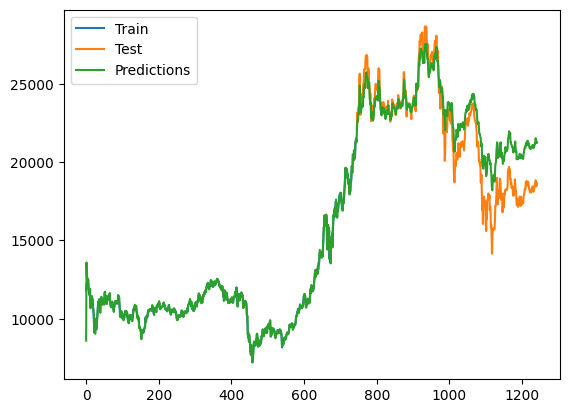

In [7]:
# 7. Đánh giá độ chính xác validate, test
valid_rmse = np.sqrt(np.mean((y_pred_val_arimax - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred_arimax - y_test)**2))
print('ARIMAX Validation RMSE:', valid_rmse)
print('ARIMAX Testing RMSE:', test_rmse)

valid_mape = np.mean(np.abs((y_pred_val_arimax - y_val) / y_val)) * 100
test_mape = np.mean(np.abs((y_pred_arimax - y_test) / y_test)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

valid_mae = np.mean(np.abs(y_pred_val_arimax - y_val))
test_mae = np.mean(np.abs(y_pred_arimax - y_test))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

# 9.Vẽ hình
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(df['Price'].index, y_pred_val_arimax)
# plt.plot(last_data,y_next_10_arima)
plt.legend(['Train', 'Test', 'Predictions','Validate'])
plt.show()